<a href="https://colab.research.google.com/github/purvankbhiwgade/SRA-tasks/blob/master/ROI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

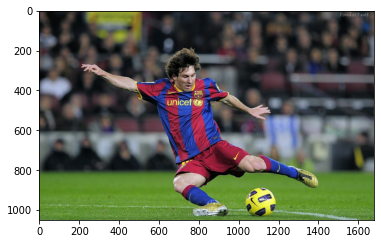

In [74]:
img = Image.open('/content/drive/My Drive/sra_tasks_images/roi.jpg')
plt.imshow(img)
img = np.array(img)

In [75]:
gaussian_kernel = np.array([[1 / 256, 4  / 256,  6 / 256,  4 / 256, 1 / 256],
                   [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
                   [6 / 256, 24 / 256, 36 / 256, 24 / 256, 6 / 256],
                   [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
                   [1 / 256, 4  / 256,  6 / 256,  4 / 256, 1 / 256]])

y_direction_kernel = np.array([[-1,-2,-1],
                              [0,0,0],
                              [1,2,1]])

x_direction_kernel = np.array([[-1,0,1], 
                                [-2,0,2], 
                                [-1,0,1]])

# img = non_max_suppression(img, theta)
# cv2_imshow(im)img

In [76]:
#canny edge detection

# Convert the image to grayscale
def rgbtogray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1],rgb[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

# Convolving the gaussian blur
def convolve_grayscale(image, kernel):
  output = np.zeros_like(image)
  image_padded = np.zeros((image.shape[0]+kernel.shape[0]-1,image.shape[1] + kernel.shape[1]-1))
  image_padded[kernel.shape[0]-2:-1,kernel.shape[1]-2:-1] = image
  image_padded[0,0] = image[0,0]
  image_padded[-1,-1] = image[-1,-1]
  for x in range(image.shape[1]):
    for y in range(image.shape[0]):
      output[y,x] = (kernel * image_padded[y: y+kernel.shape[0], x:x+kernel.shape[1]]).sum()
  return output

def non_max_suppression(img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z


# Threshold the image
def threshold(img):
        highThreshold=0.17
        lowThreshold=0.09
        strong_pixel=255
        weak_pixel=100
        highThreshold = img.max() * highThreshold;
        lowThreshold = highThreshold * lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(weak_pixel)
        strong = np.int32(strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)


# cv2_imshow(thressed)
# Hysterises the image
def hysteresis(img):
        weak_pixel=100
        strong_pixel=255
        M, N = img.shape
        weak = weak_pixel
        strong = strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
# hysterised = hysteresis(thressed)

# cv2_imshow(hysterised)

(1050, 1680)


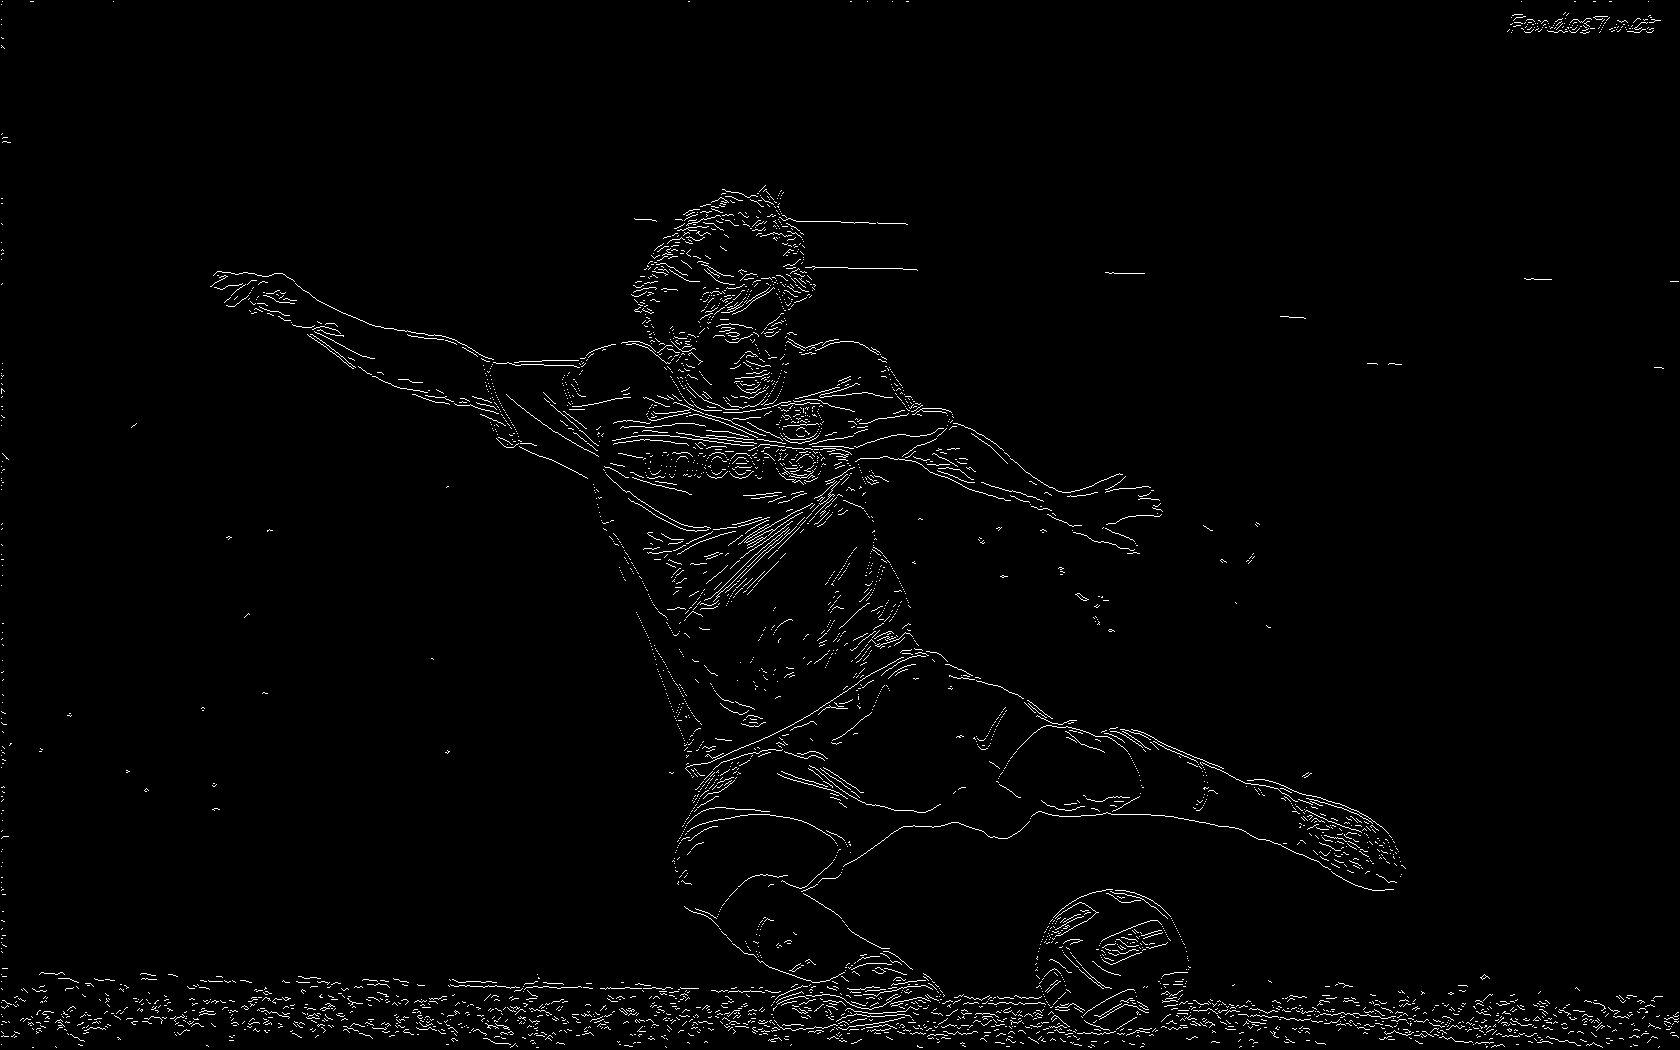

In [77]:
img = rgbtogray(img)
# plt.show(img)
# cv2_imshow(img)
print(img.shape)

img = convolve_grayscale(img, gaussian_kernel)
x_intensity = convolve_grayscale(img,x_direction_kernel)

y_intensity = convolve_grayscale(img,y_direction_kernel)
im = np.hypot(x_intensity, y_intensity)
im = im / im.max() * 255
theta = np.arctan(y_intensity,x_intensity)

suppressed = non_max_suppression(im,theta)
thressed = threshold(suppressed)

output = hysteresis(thressed)
cv2_imshow(output)
# plt.show(output)

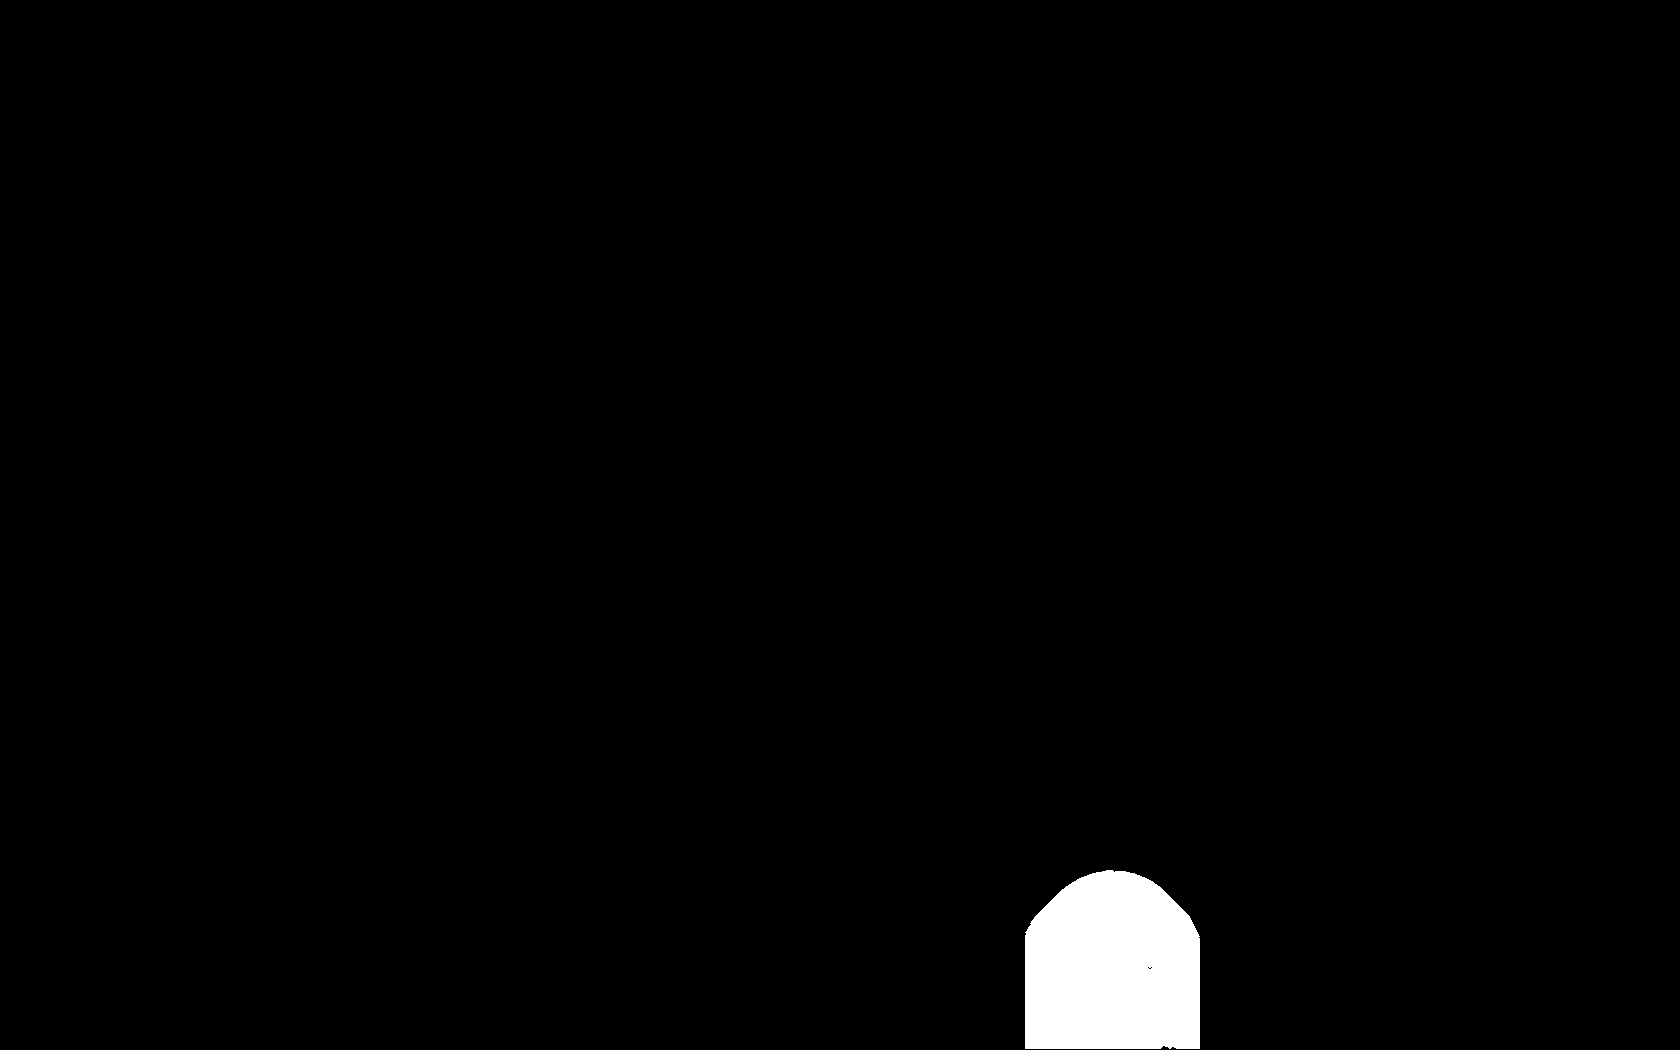

In [88]:
dilation = [[0,1,0],
            [1,1,1],
            [0,1,0]]

def erode(image):
  erroded = np.zeros([image.shape[0],image.shape[1]])
  for i in range(850,image.shape[0]-1):
    for j in range(1025,1200):
      multiplied = (dilation*image[i-1:i+2,j-1:j+2]).sum()
      if(int(multiplied / 255) != 0): 
        erroded[i,j] = 255
      else:
        erroded[i,j] = 0
  return erroded

ball_img = erode(output)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)

ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)
ball_img = erode(ball_img)


cv2_imshow(ball_img)